# Synthetic data on and Amazon Sagemaker

### A step-by-step tutorial on data synthesis using Amazon Sagemaker

This notebook is a step-by-step tutorial on how you can use Amazon Sagemaker for data synthesis. Specifically we will cover 5 steps:


    1. Set up your Amazon Sagemaker Instance
    2. Download/Extract the real data set which we use to create synthetic data
    3. Train the synthesizers and create the model
    4. Sample synthetic data from the Synthesizer
    5. Compare and evaluate the synthetic data against the real data

## Step 1: Set up your Amazon Sagemaker Instance

This is the most straightforward process, and there is plenty of documentation available incase you'd need some help. Login to your AWS portal and simply search for "Sagemaker". You'll be presented with something like the image below. Click on "Notebook instance" on the left bar, and click on "Create notebook instance".

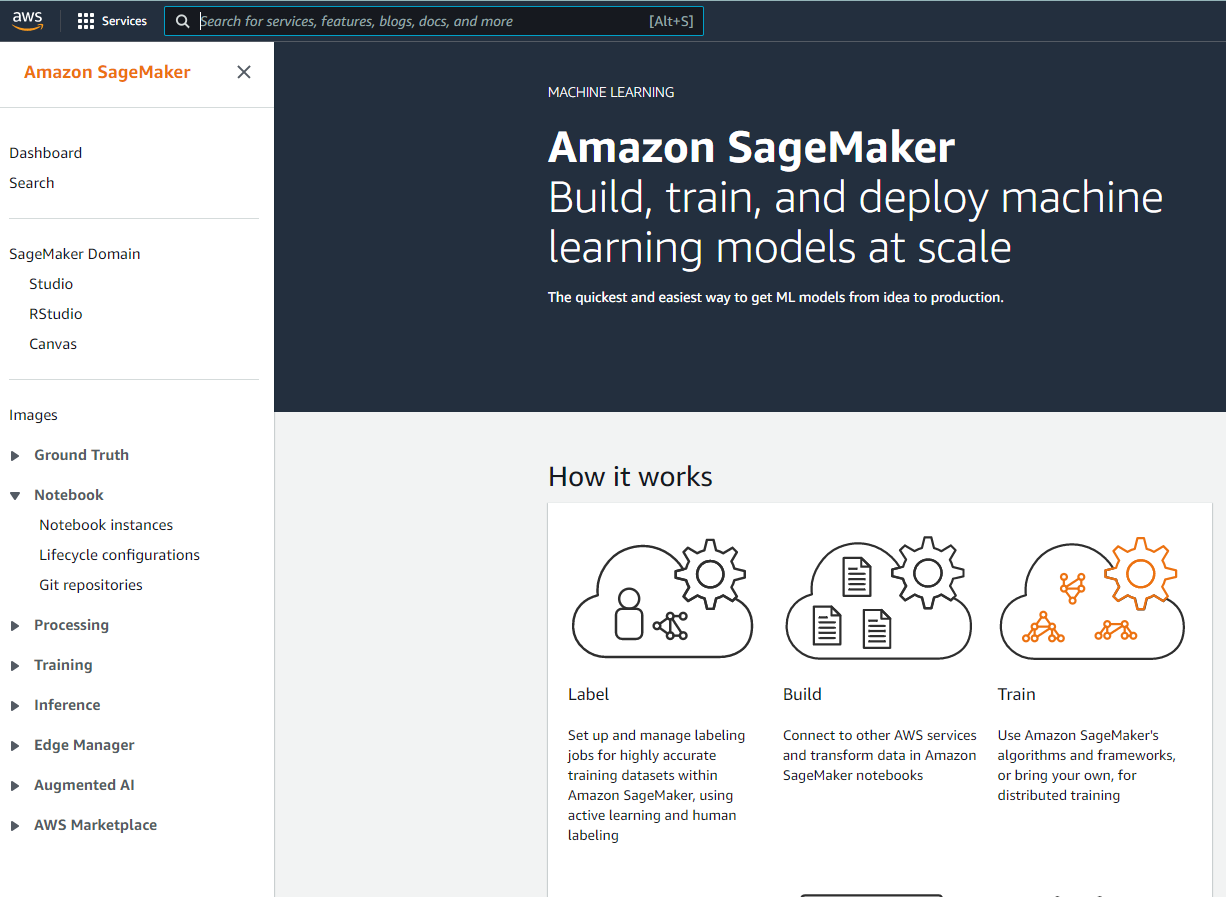

In [1]:
from IPython import display
display.Image("./img/amazon_sagemaker.png")

From the next page (as in image below), select the configurations of the VMs as per your need, and click "create notebook instance". Within a few minutes a notebook instance would be ready for you to use. 

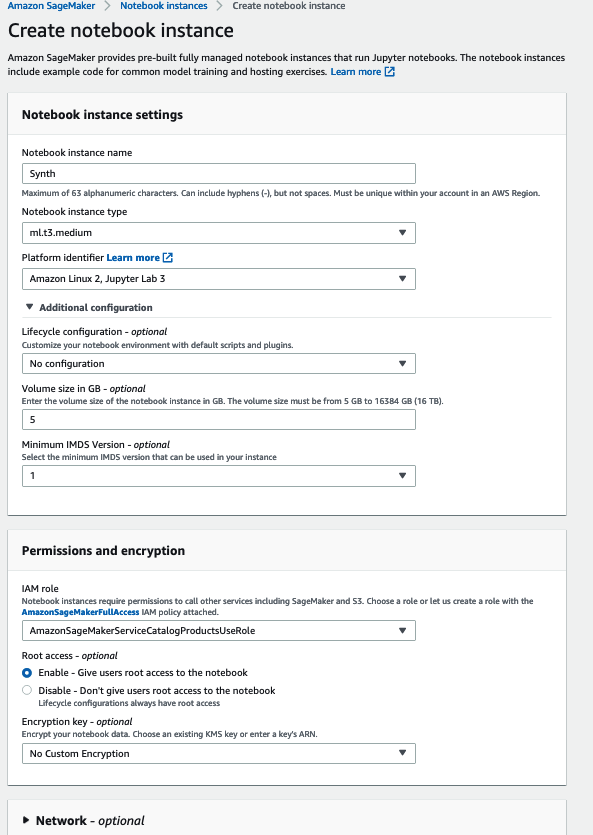

I will use JupyterLab, so I'd click on "Open JupyterLab" to launch and use it as I would normally do.

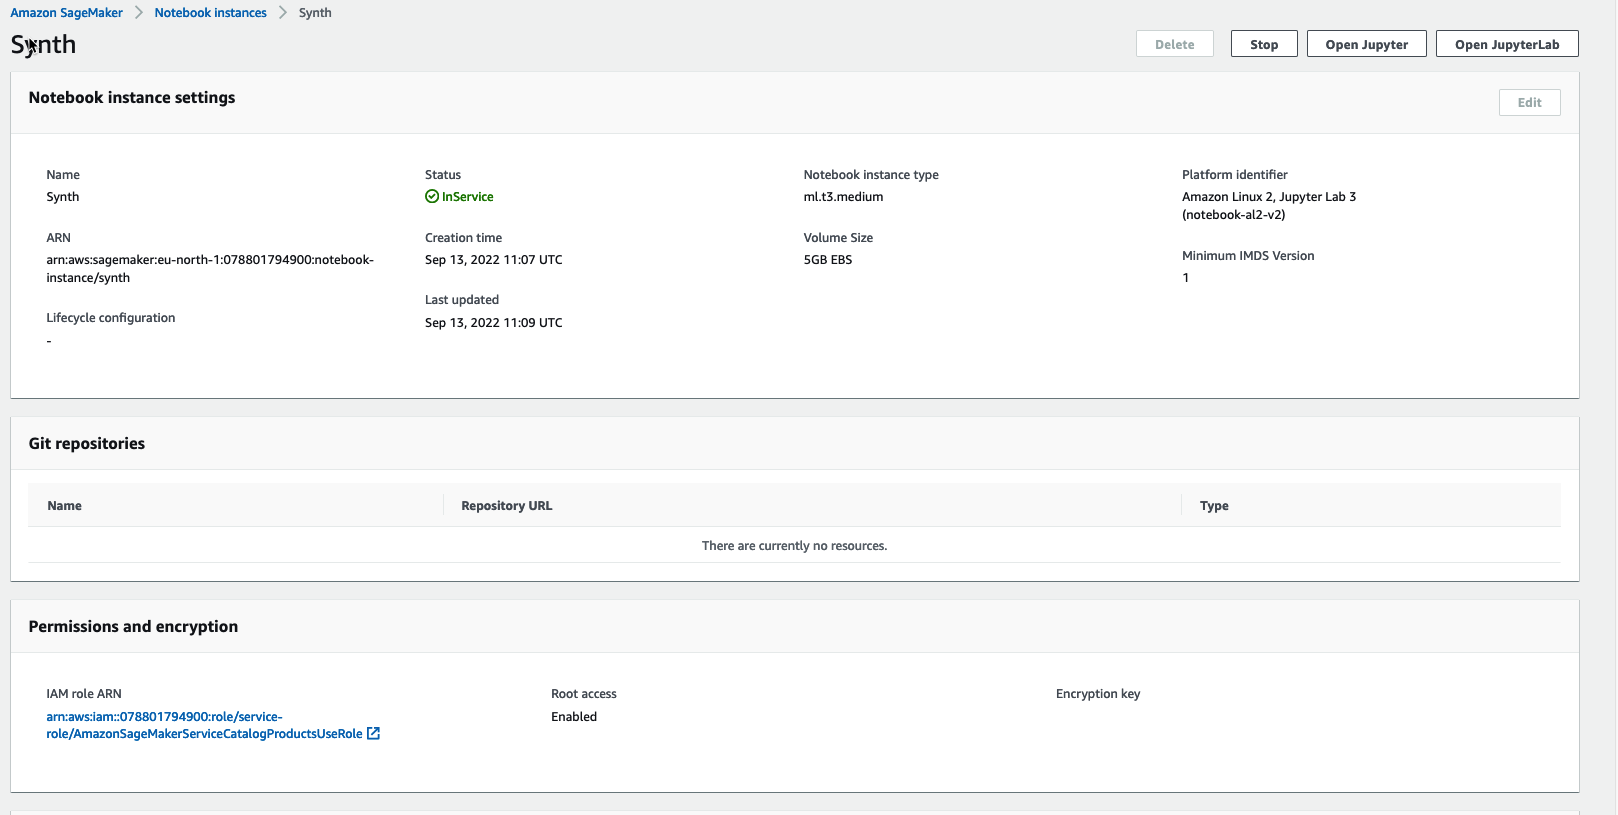

Finally, don't forget to pip install the ydata-synthetic library to get started.

In [2]:
!pip install ydata-synthetic

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 KB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 354.1 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.7/280.7 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 KB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 33.2 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 28.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 27.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.5/394.5 MB 1.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 KB 1.1 MB/s eta 0:00:00ta 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━

## Step 2: Download/Extract the real data set which we use to create synthetic data

To move forward, we pick an use-case example of "The Credit Card Fraud Dataset - Synthesizing the Minority Class" where we aim to synthesize the minority class of the credit card fraud dataset that has a high imbalance.Further a practical exercise is presented to showcase the usage of the YData Synthetic library along with GANs to synthesize tabular data. For the purpose of this exercise, dataset of credit card fraud from Kaggle is used, that can be found here: https://www.kaggle.com/mlg-ulb/creditcardfraud

In [ ]:
Create a folder called Data and upload the downloaded creditcard.csv file

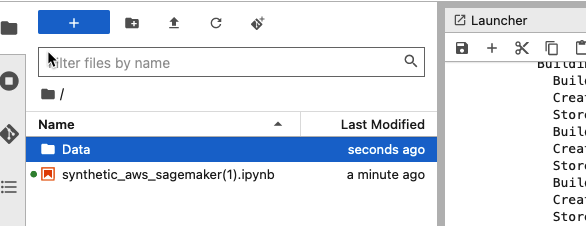

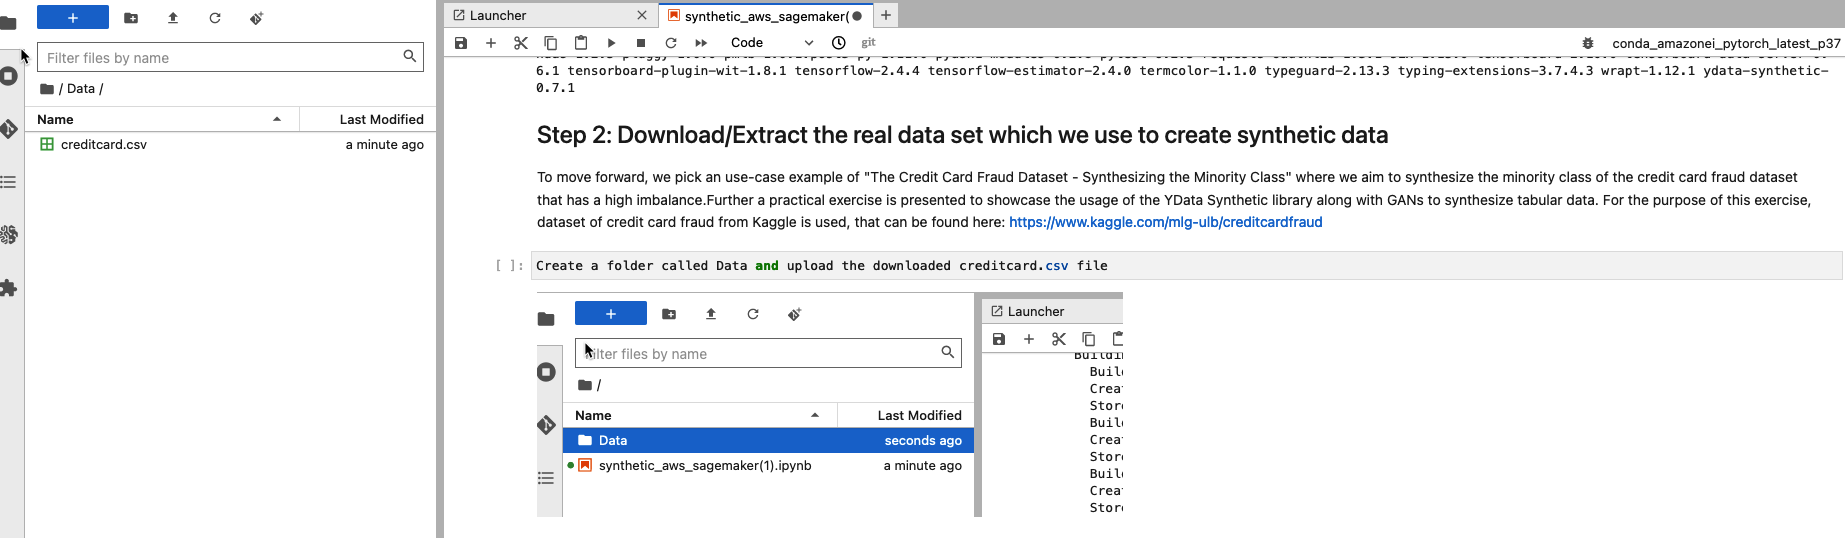

In [10]:
# importing all required libraries

import os
import pandas as pd
import numpy as np
import sklearn.cluster as cluster
import matplotlib.pyplot as plt

from ydata_synthetic.synthesizers.regular import WGAN_GP
from ydata_synthetic.synthesizers import ModelParameters, TrainParameters
from ydata_synthetic.postprocessing.regular.inverse_preprocesser import inverse_transform

model = WGAN_GP

In [12]:
# Read the original data
data = pd.read_csv('creditcard.csv')

In [13]:
#List of columns different from the Class column
num_cols = list(data.columns[ data.columns != 'Class' ])

cat_cols = ['Class']

sorted_cols = ['V14', 'V4', 'V10', 'V17', 'V12', 'V26', 'Amount', 'V21', 'V8', 'V11', 'V7', 'V28', 'V19', 'V3', 'V22', 'V6', 'V20', 'V27', 'V16', 'V13', 'V25', 'V24', 'V18', 'V2', 'V1', 'V5', 'V15', 'V9', 'V23', 'Class']

processed_data = data[ sorted_cols ].copy()

In [14]:
# For the purpose of this example we will only synthesize the minority class
# train_data contains 492 rows which had 'Class' value as 1 (which were very few)
train_data = data.loc[ data['Class']==1 ].copy()

print("Dataset info: Number of records - {} Number of variables - {}".format(train_data.shape[0], train_data.shape[1]))

# We define a K-means clustering method using sklearn, and declare that
# we want 2 clusters. We then apply this algorithm (fit_predict) to our train_data
# We essentially get an array of 492 rows ('labels') having values either 0 or 1 for the 2 clustered classes.
algorithm = cluster.KMeans
args, kwds = (), {'n_clusters':2, 'random_state':0}
labels = algorithm(*args, **kwds).fit_predict(train_data[ num_cols ])

# Get the count of both classes
print( pd.DataFrame( [ [sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )

# Assign the k-means clustered classes' labels to the a seperate copy of train data 'fraud_w_classes'
fraud_w_classes = train_data.copy()
fraud_w_classes['Class'] = labels

Dataset info: Number of records - 492 Number of variables - 31
   count
0    281
1    211


## Step 3: Train the synthesizers and create the model

Below you can try to train your own generators using the available GANs architectures. You can train it either with labels (created using KMeans) or with no labels at all.

Remember that for this exercise in particular we've decided to synthesize only the minority class from the Credit Fraud dataset.

In [15]:
# Define the GAN and training parameters
noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
epochs = 500+1
learning_rate = 5e-4
beta_1 = 0.5
beta_2 = 0.9
models_dir = './cache'

#Setting the GAN model parameters and the training step parameters
gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           betas=(beta_1, beta_2),
                           noise_dim=noise_dim,
                           layers_dim=dim)

train_args = TrainParameters(epochs=epochs,
                             sample_interval=log_step)

In [16]:
# Training the GAN model chosen: Vanilla GAN, CGAN, DCGAN, etc.
synthesizer = model(gan_args,  n_critic=2)
synthesizer.train(data = fraud_w_classes, train_arguments = train_args, num_cols = num_cols, cat_cols = cat_cols)

2022-09-13 11:51:07.982447: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-13 11:51:07.983522: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-13 11:51:08.177742: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-13 11:51:08.177785: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-33-103.eu-north-1.compute.internal): /proc/driver/nvidia/version does not exist
2022-09-13 11:51:08.212492: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appr

Epoch: 0 | disc_loss: 0.9803772568702698 | gen_loss: -0.0037544346414506435
Epoch: 1 | disc_loss: 0.11409430205821991 | gen_loss: -0.022221343591809273


  1%|          | 4/501 [00:02<03:30,  2.36it/s]

Epoch: 2 | disc_loss: -0.08760252594947815 | gen_loss: -0.009007520042359829
Epoch: 3 | disc_loss: -0.08486064523458481 | gen_loss: -0.010715031065046787


  1%|          | 6/501 [00:02<02:16,  3.62it/s]

Epoch: 4 | disc_loss: -0.06622358411550522 | gen_loss: 0.013903461396694183
Epoch: 5 | disc_loss: -0.03502929210662842 | gen_loss: 0.010547367855906487


  2%|▏         | 8/501 [00:03<01:52,  4.37it/s]

Epoch: 6 | disc_loss: -0.09249074757099152 | gen_loss: -0.02367335930466652
Epoch: 7 | disc_loss: -0.04979722201824188 | gen_loss: -0.03775259107351303


  2%|▏         | 10/501 [00:03<01:34,  5.17it/s]

Epoch: 8 | disc_loss: -0.016588706523180008 | gen_loss: -0.04195409268140793
Epoch: 9 | disc_loss: 0.08842073380947113 | gen_loss: -0.05413435399532318


  2%|▏         | 12/501 [00:03<01:25,  5.69it/s]

Epoch: 10 | disc_loss: 0.03083093836903572 | gen_loss: -0.030518788844347
Epoch: 11 | disc_loss: 0.06745609641075134 | gen_loss: -0.0625467598438263


  3%|▎         | 14/501 [00:04<01:26,  5.61it/s]

Epoch: 12 | disc_loss: -0.0076699815690517426 | gen_loss: -0.05248620733618736
Epoch: 13 | disc_loss: 0.7962640523910522 | gen_loss: -0.022156383842229843


  3%|▎         | 16/501 [00:04<01:22,  5.85it/s]

Epoch: 14 | disc_loss: -0.03596718981862068 | gen_loss: -0.012023011222481728
Epoch: 15 | disc_loss: 0.022054914385080338 | gen_loss: -0.03860636427998543


  4%|▎         | 18/501 [00:04<01:22,  5.86it/s]

Epoch: 16 | disc_loss: -0.011401038616895676 | gen_loss: -0.01612570323050022
Epoch: 17 | disc_loss: -0.03002898022532463 | gen_loss: -0.022653669118881226


  4%|▍         | 20/501 [00:05<01:17,  6.21it/s]

Epoch: 18 | disc_loss: -0.028921110555529594 | gen_loss: -0.019439099356532097
Epoch: 19 | disc_loss: -0.025695091113448143 | gen_loss: -0.016278795897960663


  4%|▍         | 22/501 [00:05<01:04,  7.46it/s]

Epoch: 20 | disc_loss: -0.03272511065006256 | gen_loss: -0.022449973970651627
Epoch: 21 | disc_loss: -0.018702158704400063 | gen_loss: -0.06244779750704765


  5%|▍         | 24/501 [00:05<00:57,  8.36it/s]

Epoch: 22 | disc_loss: 0.0014083683490753174 | gen_loss: -0.004831872880458832
Epoch: 23 | disc_loss: 0.16202105581760406 | gen_loss: -0.0009286872809752822


  5%|▌         | 26/501 [00:05<00:54,  8.78it/s]

Epoch: 24 | disc_loss: 0.179464191198349 | gen_loss: -0.0063129011541605
Epoch: 25 | disc_loss: 0.2447318732738495 | gen_loss: -0.025098945945501328


  6%|▌         | 28/501 [00:06<00:52,  9.01it/s]

Epoch: 26 | disc_loss: 0.013061420992016792 | gen_loss: 0.009085605852305889
Epoch: 27 | disc_loss: 0.0435062050819397 | gen_loss: -0.018450956791639328


  6%|▌         | 30/501 [00:06<00:51,  9.07it/s]

Epoch: 28 | disc_loss: 0.022930610924959183 | gen_loss: 0.017538467422127724
Epoch: 29 | disc_loss: 0.17566251754760742 | gen_loss: 0.012238474562764168


  6%|▋         | 32/501 [00:06<00:51,  9.17it/s]

Epoch: 30 | disc_loss: -0.026879044249653816 | gen_loss: 0.010800684802234173
Epoch: 31 | disc_loss: 0.2139773815870285 | gen_loss: 0.0034327730536460876


  7%|▋         | 34/501 [00:06<00:50,  9.16it/s]

Epoch: 32 | disc_loss: -0.0003701988607645035 | gen_loss: -0.004673665389418602
Epoch: 33 | disc_loss: 0.000953400507569313 | gen_loss: 0.008908528834581375


  7%|▋         | 36/501 [00:07<00:50,  9.22it/s]

Epoch: 34 | disc_loss: 0.14543667435646057 | gen_loss: 0.00239817937836051
Epoch: 35 | disc_loss: -0.014885906130075455 | gen_loss: -0.0033007541205734015


  8%|▊         | 38/501 [00:07<00:51,  8.96it/s]

Epoch: 36 | disc_loss: 0.07740849256515503 | gen_loss: 0.02396867796778679
Epoch: 37 | disc_loss: 0.09997064620256424 | gen_loss: -0.0005597975105047226


  8%|▊         | 40/501 [00:07<00:50,  9.13it/s]

Epoch: 38 | disc_loss: -0.00594855472445488 | gen_loss: 0.018234219402074814
Epoch: 39 | disc_loss: 0.0494728721678257 | gen_loss: 0.012478185817599297


  8%|▊         | 42/501 [00:07<00:50,  9.17it/s]

Epoch: 40 | disc_loss: 0.017512066289782524 | gen_loss: 0.009604575112462044
Epoch: 41 | disc_loss: 0.12208130955696106 | gen_loss: -0.011569930240511894


  9%|▉         | 44/501 [00:07<00:49,  9.22it/s]

Epoch: 42 | disc_loss: 0.2843073010444641 | gen_loss: 0.013643525540828705
Epoch: 43 | disc_loss: -0.003770332783460617 | gen_loss: 0.022944550961256027


  9%|▉         | 46/501 [00:08<00:48,  9.38it/s]

Epoch: 44 | disc_loss: -0.01995108649134636 | gen_loss: 0.044617608189582825
Epoch: 45 | disc_loss: 0.15001918375492096 | gen_loss: 0.021332068368792534


 10%|▉         | 48/501 [00:08<00:48,  9.26it/s]

Epoch: 46 | disc_loss: -0.020682470872998238 | gen_loss: 0.024388520047068596
Epoch: 47 | disc_loss: 0.1265689730644226 | gen_loss: 0.004396364092826843


 10%|▉         | 50/501 [00:08<00:48,  9.34it/s]

Epoch: 48 | disc_loss: 0.01670527458190918 | gen_loss: 0.031891219317913055
Epoch: 49 | disc_loss: -0.028277313336730003 | gen_loss: 0.03583800047636032


 10%|█         | 52/501 [00:08<00:47,  9.40it/s]

Epoch: 50 | disc_loss: 0.1618727296590805 | gen_loss: 0.03117459826171398
Epoch: 51 | disc_loss: -0.02424003556370735 | gen_loss: 0.04797369986772537


 11%|█         | 54/501 [00:08<00:48,  9.26it/s]

Epoch: 52 | disc_loss: 0.07097624242305756 | gen_loss: 0.049020662903785706
Epoch: 53 | disc_loss: -0.011620590463280678 | gen_loss: 0.044490233063697815


 11%|█         | 56/501 [00:09<00:49,  8.99it/s]

Epoch: 54 | disc_loss: 0.043378204107284546 | gen_loss: 0.05044186860322952
Epoch: 55 | disc_loss: -0.028172340244054794 | gen_loss: 0.04811299592256546


 12%|█▏        | 58/501 [00:09<00:48,  9.07it/s]

Epoch: 56 | disc_loss: -0.02574944868683815 | gen_loss: 0.05440285801887512
Epoch: 57 | disc_loss: 0.002210773527622223 | gen_loss: 0.06422577053308487


 12%|█▏        | 60/501 [00:09<00:47,  9.19it/s]

Epoch: 58 | disc_loss: 0.14325852692127228 | gen_loss: 0.04228514805436134
Epoch: 59 | disc_loss: 0.1378747820854187 | gen_loss: 0.026081815361976624


 12%|█▏        | 62/501 [00:09<00:48,  9.06it/s]

Epoch: 60 | disc_loss: 0.047782961279153824 | gen_loss: 0.019525382667779922
Epoch: 61 | disc_loss: -0.01508183591067791 | gen_loss: 0.031427837908267975


 13%|█▎        | 64/501 [00:10<00:47,  9.12it/s]

Epoch: 62 | disc_loss: 0.03523735702037811 | gen_loss: 0.006495708599686623
Epoch: 63 | disc_loss: -0.028234750032424927 | gen_loss: 0.007882792502641678


 13%|█▎        | 66/501 [00:10<00:48,  8.89it/s]

Epoch: 64 | disc_loss: -0.008700085803866386 | gen_loss: -0.011822721920907497
Epoch: 65 | disc_loss: 0.014400284737348557 | gen_loss: -0.023002006113529205


 14%|█▎        | 68/501 [00:10<00:47,  9.08it/s]

Epoch: 66 | disc_loss: 0.003304477781057358 | gen_loss: -0.015313273295760155
Epoch: 67 | disc_loss: -0.0005461461842060089 | gen_loss: 0.008644353598356247


 14%|█▍        | 70/501 [00:10<00:47,  9.16it/s]

Epoch: 68 | disc_loss: 0.14989596605300903 | gen_loss: -0.005100499372929335
Epoch: 69 | disc_loss: 0.04005647450685501 | gen_loss: -0.01327016856521368


 14%|█▍        | 72/501 [00:10<00:46,  9.20it/s]

Epoch: 70 | disc_loss: -0.013401592150330544 | gen_loss: -0.00865698978304863
Epoch: 71 | disc_loss: -0.006969215348362923 | gen_loss: -0.0012613949365913868


 15%|█▍        | 74/501 [00:11<00:46,  9.21it/s]

Epoch: 72 | disc_loss: -0.02370803989470005 | gen_loss: -0.030575502663850784
Epoch: 73 | disc_loss: -0.02538330666720867 | gen_loss: -0.006441871635615826


 15%|█▌        | 76/501 [00:11<00:46,  9.07it/s]

Epoch: 74 | disc_loss: -0.023402206599712372 | gen_loss: -0.004513919353485107
Epoch: 75 | disc_loss: -0.027158794924616814 | gen_loss: -0.002732580993324518


 16%|█▌        | 78/501 [00:11<00:46,  9.10it/s]

Epoch: 76 | disc_loss: 0.03910668194293976 | gen_loss: -0.009444511495530605
Epoch: 77 | disc_loss: 0.1332143098115921 | gen_loss: -0.03908977285027504


 16%|█▌        | 80/501 [00:11<00:46,  9.13it/s]

Epoch: 78 | disc_loss: -0.02217916212975979 | gen_loss: -0.0013034195872023702
Epoch: 79 | disc_loss: -0.008962107822299004 | gen_loss: -0.02079537697136402


 16%|█▋        | 82/501 [00:12<00:45,  9.31it/s]

Epoch: 80 | disc_loss: 0.011257519945502281 | gen_loss: -0.0073041836731135845
Epoch: 81 | disc_loss: 0.15568140149116516 | gen_loss: -0.011003351770341396


 17%|█▋        | 84/501 [00:12<00:45,  9.09it/s]

Epoch: 82 | disc_loss: 0.02086735889315605 | gen_loss: -0.026915160939097404
Epoch: 83 | disc_loss: -0.008511433377861977 | gen_loss: -0.009775035083293915


 17%|█▋        | 86/501 [00:12<00:45,  9.11it/s]

Epoch: 84 | disc_loss: -0.02004263550043106 | gen_loss: -0.018628966063261032
Epoch: 85 | disc_loss: -0.006732605397701263 | gen_loss: -0.013388186693191528


 18%|█▊        | 88/501 [00:12<00:44,  9.27it/s]

Epoch: 86 | disc_loss: -0.018898634240031242 | gen_loss: 0.03249422460794449
Epoch: 87 | disc_loss: 0.045239150524139404 | gen_loss: -0.041941363364458084


 18%|█▊        | 90/501 [00:12<00:44,  9.15it/s]

Epoch: 88 | disc_loss: -0.0016169603914022446 | gen_loss: -0.017054403200745583
Epoch: 89 | disc_loss: -0.018739335238933563 | gen_loss: -0.0006687170825898647


 18%|█▊        | 92/501 [00:13<00:43,  9.36it/s]

Epoch: 90 | disc_loss: -0.005262870341539383 | gen_loss: -0.031042687594890594
Epoch: 91 | disc_loss: -0.03305912762880325 | gen_loss: -0.018544437363743782


 19%|█▉        | 94/501 [00:13<00:44,  9.16it/s]

Epoch: 92 | disc_loss: 0.011091947555541992 | gen_loss: -0.03512419015169144
Epoch: 93 | disc_loss: 0.010922610759735107 | gen_loss: -0.02236269600689411


 19%|█▉        | 96/501 [00:13<00:43,  9.38it/s]

Epoch: 94 | disc_loss: 0.023545697331428528 | gen_loss: -0.04196379333734512
Epoch: 95 | disc_loss: -0.02823992446064949 | gen_loss: -0.025330591946840286


 20%|█▉        | 98/501 [00:13<00:42,  9.42it/s]

Epoch: 96 | disc_loss: 0.030194349586963654 | gen_loss: -0.010316740721464157
Epoch: 97 | disc_loss: -0.019757797941565514 | gen_loss: -0.045647699385881424


 20%|█▉        | 100/501 [00:13<00:42,  9.44it/s]

Epoch: 98 | disc_loss: 0.11574985086917877 | gen_loss: -0.0095160948112607
Epoch: 99 | disc_loss: 0.024346008896827698 | gen_loss: -0.011883954517543316


 20%|██        | 102/501 [00:14<00:43,  9.25it/s]

Epoch: 100 | disc_loss: 0.3598819077014923 | gen_loss: 0.048926737159490585
Epoch: 101 | disc_loss: 0.12021768093109131 | gen_loss: 0.028845414519309998


 21%|██        | 104/501 [00:14<00:43,  9.15it/s]

Epoch: 102 | disc_loss: -0.02991158328950405 | gen_loss: 0.045548003166913986
Epoch: 103 | disc_loss: 0.16592742502689362 | gen_loss: 0.047467537224292755


 21%|██        | 106/501 [00:14<00:42,  9.27it/s]

Epoch: 104 | disc_loss: -0.01448990497738123 | gen_loss: -0.008999009616672993
Epoch: 105 | disc_loss: -0.018595919013023376 | gen_loss: -0.021250182762742043


 22%|██▏       | 108/501 [00:14<00:43,  9.11it/s]

Epoch: 106 | disc_loss: -0.007283627986907959 | gen_loss: 0.0010535084875300527
Epoch: 107 | disc_loss: 0.005949126556515694 | gen_loss: -0.06910300254821777


 22%|██▏       | 110/501 [00:15<00:42,  9.20it/s]

Epoch: 108 | disc_loss: -0.025433003902435303 | gen_loss: -0.03000517003238201
Epoch: 109 | disc_loss: -0.011935040354728699 | gen_loss: 0.00407974561676383


 22%|██▏       | 112/501 [00:15<00:43,  9.04it/s]

Epoch: 110 | disc_loss: 0.12698429822921753 | gen_loss: -0.008166848681867123
Epoch: 111 | disc_loss: -0.02065439522266388 | gen_loss: 0.017375562340021133


 23%|██▎       | 114/501 [00:15<00:42,  9.04it/s]

Epoch: 112 | disc_loss: 0.021672599017620087 | gen_loss: -0.06698861718177795
Epoch: 113 | disc_loss: 0.05406428128480911 | gen_loss: -0.0009898495627567172


 23%|██▎       | 116/501 [00:15<00:41,  9.24it/s]

Epoch: 114 | disc_loss: 0.013352595269680023 | gen_loss: -0.023356201127171516
Epoch: 115 | disc_loss: -0.009021822363138199 | gen_loss: 0.001340382033959031


 24%|██▎       | 118/501 [00:15<00:41,  9.22it/s]

Epoch: 116 | disc_loss: -0.009304486215114594 | gen_loss: -0.060907721519470215
Epoch: 117 | disc_loss: -0.017181096598505974 | gen_loss: 0.009207582101225853


 24%|██▍       | 120/501 [00:16<00:41,  9.26it/s]

Epoch: 118 | disc_loss: 0.01533639058470726 | gen_loss: 0.004273124039173126
Epoch: 119 | disc_loss: -0.019650377333164215 | gen_loss: 0.008089244365692139


 24%|██▍       | 122/501 [00:16<00:40,  9.29it/s]

Epoch: 120 | disc_loss: -0.029002338647842407 | gen_loss: 0.00025405187625437975
Epoch: 121 | disc_loss: 0.03065657988190651 | gen_loss: 0.01600525714457035


 25%|██▍       | 124/501 [00:16<00:40,  9.41it/s]

Epoch: 122 | disc_loss: 0.0027066580951213837 | gen_loss: -0.06524547934532166
Epoch: 123 | disc_loss: -0.01856154575943947 | gen_loss: -0.058315690606832504


 25%|██▌       | 126/501 [00:16<00:39,  9.44it/s]

Epoch: 124 | disc_loss: -0.024397172033786774 | gen_loss: -0.03100118786096573
Epoch: 125 | disc_loss: -0.01707153208553791 | gen_loss: -0.008122261613607407


 26%|██▌       | 128/501 [00:17<00:39,  9.47it/s]

Epoch: 126 | disc_loss: -0.02571798488497734 | gen_loss: -0.03718290477991104
Epoch: 127 | disc_loss: -0.02771831303834915 | gen_loss: -0.06513474881649017


 26%|██▌       | 130/501 [00:17<00:39,  9.46it/s]

Epoch: 128 | disc_loss: -0.02677205577492714 | gen_loss: -0.03758483752608299
Epoch: 129 | disc_loss: 0.03491333872079849 | gen_loss: -0.0656074658036232


 26%|██▋       | 132/501 [00:17<00:40,  9.22it/s]

Epoch: 130 | disc_loss: -0.03336349502205849 | gen_loss: -0.0411197692155838
Epoch: 131 | disc_loss: 0.016142040491104126 | gen_loss: -0.026009075343608856


 27%|██▋       | 134/501 [00:17<00:39,  9.27it/s]

Epoch: 132 | disc_loss: 0.014145493507385254 | gen_loss: -0.06399762630462646
Epoch: 133 | disc_loss: -0.03117883950471878 | gen_loss: -0.05546942725777626


 27%|██▋       | 136/501 [00:17<00:39,  9.28it/s]

Epoch: 134 | disc_loss: -0.002608686685562134 | gen_loss: -0.05018552020192146
Epoch: 135 | disc_loss: 0.0650915801525116 | gen_loss: 0.04735177382826805


 28%|██▊       | 138/501 [00:18<00:38,  9.39it/s]

Epoch: 136 | disc_loss: -0.004196954891085625 | gen_loss: 0.03686492517590523
Epoch: 137 | disc_loss: 0.020499559119343758 | gen_loss: 0.010558255948126316


 28%|██▊       | 140/501 [00:18<00:39,  9.15it/s]

Epoch: 138 | disc_loss: -0.027080178260803223 | gen_loss: -0.007690570317208767
Epoch: 139 | disc_loss: -0.03759785369038582 | gen_loss: -0.019059184938669205


 28%|██▊       | 142/501 [00:18<00:38,  9.24it/s]

Epoch: 140 | disc_loss: -0.021954137831926346 | gen_loss: -0.02355402149260044
Epoch: 141 | disc_loss: 0.12448693811893463 | gen_loss: -0.020443137735128403


 29%|██▊       | 144/501 [00:18<00:38,  9.23it/s]

Epoch: 142 | disc_loss: -0.026705268770456314 | gen_loss: -0.05327630043029785
Epoch: 143 | disc_loss: 0.10124197602272034 | gen_loss: -0.01332844514399767


 29%|██▉       | 146/501 [00:18<00:38,  9.15it/s]

Epoch: 144 | disc_loss: 0.056952789425849915 | gen_loss: -0.06049308925867081
Epoch: 145 | disc_loss: 0.0013925377279520035 | gen_loss: -0.09559141099452972


 30%|██▉       | 148/501 [00:19<00:38,  9.20it/s]

Epoch: 146 | disc_loss: 0.01187528669834137 | gen_loss: -0.04184681177139282
Epoch: 147 | disc_loss: 0.19157667458057404 | gen_loss: -0.043443240225315094


 30%|██▉       | 150/501 [00:19<00:39,  8.99it/s]

Epoch: 148 | disc_loss: -0.026473626494407654 | gen_loss: -0.03944648057222366
Epoch: 149 | disc_loss: 0.0262964628636837 | gen_loss: -0.06296241283416748


 30%|███       | 152/501 [00:19<00:38,  9.15it/s]

Epoch: 150 | disc_loss: -0.019899707287549973 | gen_loss: -0.06376489996910095
Epoch: 151 | disc_loss: -0.008261829614639282 | gen_loss: -0.043943461030721664


 31%|███       | 154/501 [00:19<00:37,  9.13it/s]

Epoch: 152 | disc_loss: -0.01858466863632202 | gen_loss: -0.055031679570674896
Epoch: 153 | disc_loss: 0.043341562151908875 | gen_loss: -0.060180820524692535


 31%|███       | 156/501 [00:20<00:37,  9.22it/s]

Epoch: 154 | disc_loss: 0.16745643317699432 | gen_loss: 0.004062083084136248
Epoch: 155 | disc_loss: 0.0004916731268167496 | gen_loss: 0.0483274906873703


 32%|███▏      | 158/501 [00:20<00:37,  9.24it/s]

Epoch: 156 | disc_loss: -0.013824851252138615 | gen_loss: -0.0040946099907159805
Epoch: 157 | disc_loss: -0.020124420523643494 | gen_loss: -0.01849772408604622


 32%|███▏      | 160/501 [00:20<00:37,  9.17it/s]

Epoch: 158 | disc_loss: -0.02296082302927971 | gen_loss: -0.03923565894365311
Epoch: 159 | disc_loss: -0.006073376163840294 | gen_loss: -0.001231496804393828


 32%|███▏      | 162/501 [00:20<00:36,  9.31it/s]

Epoch: 160 | disc_loss: -0.013012458570301533 | gen_loss: -0.03552683815360069
Epoch: 161 | disc_loss: -0.0325494259595871 | gen_loss: -0.023530125617980957


 33%|███▎      | 164/501 [00:20<00:36,  9.25it/s]

Epoch: 162 | disc_loss: 0.09877350926399231 | gen_loss: -0.04125951603055
Epoch: 163 | disc_loss: -0.02493063360452652 | gen_loss: -0.03620114177465439


 33%|███▎      | 166/501 [00:21<00:35,  9.32it/s]

Epoch: 164 | disc_loss: -0.02007635310292244 | gen_loss: -0.10105948150157928
Epoch: 165 | disc_loss: -0.010354582220315933 | gen_loss: -0.06516188383102417


 34%|███▎      | 168/501 [00:21<00:36,  9.23it/s]

Epoch: 166 | disc_loss: 0.0008591972291469574 | gen_loss: -0.0010669748298823833
Epoch: 167 | disc_loss: 0.020191017538309097 | gen_loss: -0.05542469769716263


 34%|███▍      | 170/501 [00:21<00:35,  9.35it/s]

Epoch: 168 | disc_loss: 0.028087809681892395 | gen_loss: -0.043226368725299835
Epoch: 169 | disc_loss: 0.01508290320634842 | gen_loss: -0.03617456555366516


 34%|███▍      | 172/501 [00:21<00:35,  9.36it/s]

Epoch: 170 | disc_loss: 0.04345144331455231 | gen_loss: -0.005174623336642981
Epoch: 171 | disc_loss: 0.006208827719092369 | gen_loss: -0.06812460720539093


 35%|███▍      | 174/501 [00:22<00:34,  9.38it/s]

Epoch: 172 | disc_loss: -0.025988103821873665 | gen_loss: -0.035712920129299164
Epoch: 173 | disc_loss: 0.3048558831214905 | gen_loss: -0.009995151311159134


 35%|███▌      | 177/501 [00:22<00:33,  9.68it/s]

Epoch: 174 | disc_loss: 0.08253933489322662 | gen_loss: -0.030919445678591728
Epoch: 175 | disc_loss: 0.04328736662864685 | gen_loss: 0.022445030510425568
Epoch: 176 | disc_loss: -0.01850375346839428 | gen_loss: 0.037995144724845886


 36%|███▌      | 179/501 [00:22<00:33,  9.54it/s]

Epoch: 177 | disc_loss: 0.07499118149280548 | gen_loss: 0.0082174027338624
Epoch: 178 | disc_loss: -0.011250174604356289 | gen_loss: -0.010795761831104755


 36%|███▌      | 181/501 [00:22<00:33,  9.56it/s]

Epoch: 179 | disc_loss: -0.025692515075206757 | gen_loss: -0.002861517481505871
Epoch: 180 | disc_loss: -0.023887908086180687 | gen_loss: -0.02558971382677555


 37%|███▋      | 183/501 [00:22<00:33,  9.50it/s]

Epoch: 181 | disc_loss: -0.012013230472803116 | gen_loss: 0.01651296392083168
Epoch: 182 | disc_loss: -0.018840910866856575 | gen_loss: 0.004047874361276627


 37%|███▋      | 185/501 [00:23<00:33,  9.47it/s]

Epoch: 183 | disc_loss: 0.03607683628797531 | gen_loss: 0.028328482061624527
Epoch: 184 | disc_loss: -0.01839658059179783 | gen_loss: 0.023253867402672768


 37%|███▋      | 187/501 [00:23<00:34,  9.23it/s]

Epoch: 185 | disc_loss: 0.15949182212352753 | gen_loss: 0.041813820600509644
Epoch: 186 | disc_loss: -0.006780410185456276 | gen_loss: 0.031229432672262192


 38%|███▊      | 189/501 [00:23<00:33,  9.18it/s]

Epoch: 187 | disc_loss: -0.029398135840892792 | gen_loss: 0.04393000900745392
Epoch: 188 | disc_loss: -0.027094073593616486 | gen_loss: 0.05208033323287964


 38%|███▊      | 191/501 [00:23<00:33,  9.20it/s]

Epoch: 189 | disc_loss: -0.016456082463264465 | gen_loss: -0.04410523176193237
Epoch: 190 | disc_loss: 0.07727645337581635 | gen_loss: -0.015290969982743263


 39%|███▊      | 193/501 [00:24<00:33,  9.28it/s]

Epoch: 191 | disc_loss: 0.1799597144126892 | gen_loss: -0.008890004828572273
Epoch: 192 | disc_loss: 0.09298981726169586 | gen_loss: -0.00016690208576619625


 39%|███▉      | 195/501 [00:24<00:32,  9.40it/s]

Epoch: 193 | disc_loss: 0.0927153080701828 | gen_loss: 0.014984083361923695
Epoch: 194 | disc_loss: -0.01840435341000557 | gen_loss: -0.00012298213550820947


 39%|███▉      | 197/501 [00:24<00:34,  8.88it/s]

Epoch: 195 | disc_loss: -0.019615497440099716 | gen_loss: -0.016810867935419083
Epoch: 196 | disc_loss: -0.018967613577842712 | gen_loss: -0.008343575522303581


 40%|███▉      | 199/501 [00:24<00:33,  9.11it/s]

Epoch: 197 | disc_loss: -0.016650456935167313 | gen_loss: -0.01563560776412487
Epoch: 198 | disc_loss: -0.010322794318199158 | gen_loss: -0.04830910265445709


 40%|████      | 201/501 [00:24<00:33,  8.88it/s]

Epoch: 199 | disc_loss: -0.007752865552902222 | gen_loss: 0.018138043582439423
Epoch: 200 | disc_loss: -0.0018474515527486801 | gen_loss: -0.007526209112256765


 41%|████      | 203/501 [00:25<00:32,  9.15it/s]

Epoch: 201 | disc_loss: -0.029401281848549843 | gen_loss: 0.033303067088127136
Epoch: 202 | disc_loss: -0.02225884236395359 | gen_loss: -0.022866535931825638


 41%|████      | 205/501 [00:25<00:32,  9.24it/s]

Epoch: 203 | disc_loss: -0.017223956063389778 | gen_loss: -0.022617414593696594
Epoch: 204 | disc_loss: 0.12196392565965652 | gen_loss: -0.05891881138086319


 41%|████▏     | 207/501 [00:25<00:32,  9.07it/s]

Epoch: 205 | disc_loss: 0.052734456956386566 | gen_loss: -0.09203582257032394
Epoch: 206 | disc_loss: -0.02373213693499565 | gen_loss: -0.0823448970913887


 42%|████▏     | 209/501 [00:25<00:31,  9.16it/s]

Epoch: 207 | disc_loss: 0.023757264018058777 | gen_loss: -0.10024696588516235
Epoch: 208 | disc_loss: -0.003403482958674431 | gen_loss: -0.09084028005599976


 42%|████▏     | 211/501 [00:26<00:31,  9.14it/s]

Epoch: 209 | disc_loss: -0.018857967108488083 | gen_loss: -0.15007133781909943
Epoch: 210 | disc_loss: -0.016273612156510353 | gen_loss: -0.11059505492448807


 43%|████▎     | 213/501 [00:26<00:31,  9.25it/s]

Epoch: 211 | disc_loss: 0.029189012944698334 | gen_loss: 0.016173504292964935
Epoch: 212 | disc_loss: -0.020852047950029373 | gen_loss: -0.08371821790933609


 43%|████▎     | 215/501 [00:26<00:31,  9.04it/s]

Epoch: 213 | disc_loss: 0.012563351541757584 | gen_loss: -0.041805945336818695
Epoch: 214 | disc_loss: -0.02552003040909767 | gen_loss: -0.09850306063890457


 43%|████▎     | 217/501 [00:26<00:30,  9.18it/s]

Epoch: 215 | disc_loss: 0.020951218903064728 | gen_loss: -0.08916506171226501
Epoch: 216 | disc_loss: -0.02789868228137493 | gen_loss: -0.10922021418809891


 44%|████▎     | 219/501 [00:26<00:30,  9.12it/s]

Epoch: 217 | disc_loss: 0.0754212886095047 | gen_loss: -0.09029468894004822
Epoch: 218 | disc_loss: -0.017837153747677803 | gen_loss: -0.06656783819198608


 44%|████▍     | 221/501 [00:27<00:30,  9.29it/s]

Epoch: 219 | disc_loss: 0.12147370725870132 | gen_loss: -0.07297959923744202
Epoch: 220 | disc_loss: 0.08712978661060333 | gen_loss: -0.08708532154560089


 45%|████▍     | 223/501 [00:27<00:29,  9.29it/s]

Epoch: 221 | disc_loss: -0.007157636806368828 | gen_loss: -0.08077316731214523
Epoch: 222 | disc_loss: -0.003434719517827034 | gen_loss: -0.07857999205589294


 45%|████▍     | 225/501 [00:27<00:30,  9.09it/s]

Epoch: 223 | disc_loss: -0.012060841545462608 | gen_loss: 0.013752072118222713
Epoch: 224 | disc_loss: 0.07714366912841797 | gen_loss: -0.11204757541418076


 45%|████▌     | 227/501 [00:27<00:29,  9.26it/s]

Epoch: 225 | disc_loss: -0.02236820198595524 | gen_loss: -0.04993963986635208
Epoch: 226 | disc_loss: -0.01661483198404312 | gen_loss: -0.06511548161506653


 46%|████▌     | 229/501 [00:28<00:29,  9.24it/s]

Epoch: 227 | disc_loss: 0.012866737321019173 | gen_loss: -0.03410496562719345
Epoch: 228 | disc_loss: -0.02698684297502041 | gen_loss: -0.04210914671421051


 46%|████▌     | 231/501 [00:28<00:28,  9.31it/s]

Epoch: 229 | disc_loss: -0.014730766415596008 | gen_loss: -0.06331862509250641
Epoch: 230 | disc_loss: -0.029304111376404762 | gen_loss: 0.016677729785442352


 47%|████▋     | 233/501 [00:28<00:28,  9.47it/s]

Epoch: 231 | disc_loss: -0.021829253062605858 | gen_loss: -0.02425481751561165
Epoch: 232 | disc_loss: -0.029637224972248077 | gen_loss: -0.045141130685806274


 47%|████▋     | 235/501 [00:28<00:28,  9.23it/s]

Epoch: 233 | disc_loss: -0.007926227524876595 | gen_loss: -0.06511811167001724
Epoch: 234 | disc_loss: 0.03223349526524544 | gen_loss: -0.0929495096206665


 47%|████▋     | 237/501 [00:28<00:28,  9.29it/s]

Epoch: 235 | disc_loss: 0.05323270708322525 | gen_loss: -0.047295935451984406
Epoch: 236 | disc_loss: 0.046205952763557434 | gen_loss: -0.05724244564771652


 48%|████▊     | 239/501 [00:29<00:28,  9.35it/s]

Epoch: 237 | disc_loss: -0.028881248086690903 | gen_loss: -0.047357551753520966
Epoch: 238 | disc_loss: 0.025120101869106293 | gen_loss: -0.02825723960995674


 48%|████▊     | 241/501 [00:29<00:27,  9.42it/s]

Epoch: 239 | disc_loss: 0.011798584833741188 | gen_loss: -0.014365212060511112
Epoch: 240 | disc_loss: 0.1153087466955185 | gen_loss: -0.051426321268081665


 49%|████▊     | 243/501 [00:29<00:27,  9.23it/s]

Epoch: 241 | disc_loss: -0.023738916963338852 | gen_loss: -0.04503384977579117
Epoch: 242 | disc_loss: 0.0456186942756176 | gen_loss: -0.00017237523570656776


 49%|████▉     | 245/501 [00:29<00:27,  9.36it/s]

Epoch: 243 | disc_loss: 0.1911950707435608 | gen_loss: 0.016024194657802582
Epoch: 244 | disc_loss: 0.00729842483997345 | gen_loss: 0.10535013675689697


 49%|████▉     | 247/501 [00:29<00:27,  9.16it/s]

Epoch: 245 | disc_loss: -0.008986559696495533 | gen_loss: 0.07074368000030518
Epoch: 246 | disc_loss: -0.019651897251605988 | gen_loss: 0.10434027761220932


 50%|████▉     | 249/501 [00:30<00:27,  9.22it/s]

Epoch: 247 | disc_loss: -0.011487605981528759 | gen_loss: 0.11622095108032227
Epoch: 248 | disc_loss: 0.002400599420070648 | gen_loss: 0.09798525273799896


 50%|█████     | 251/501 [00:30<00:26,  9.30it/s]

Epoch: 249 | disc_loss: -0.009886985644698143 | gen_loss: 0.0821891650557518
Epoch: 250 | disc_loss: -0.027703536674380302 | gen_loss: 0.0751427412033081


 50%|█████     | 253/501 [00:30<00:26,  9.19it/s]

Epoch: 251 | disc_loss: -0.010433247312903404 | gen_loss: 0.07603931427001953
Epoch: 252 | disc_loss: -0.020632773637771606 | gen_loss: 0.06811849772930145


 51%|█████     | 255/501 [00:30<00:26,  9.26it/s]

Epoch: 253 | disc_loss: -0.01878371834754944 | gen_loss: 0.04255397990345955
Epoch: 254 | disc_loss: -0.024467255920171738 | gen_loss: 0.05376466363668442


 51%|█████▏    | 257/501 [00:31<00:26,  9.22it/s]

Epoch: 255 | disc_loss: -0.02975897490978241 | gen_loss: 0.04315446317195892
Epoch: 256 | disc_loss: 0.08563520014286041 | gen_loss: 0.07314188033342361


 52%|█████▏    | 259/501 [00:31<00:26,  9.30it/s]

Epoch: 257 | disc_loss: 0.09295889735221863 | gen_loss: 0.033056534826755524
Epoch: 258 | disc_loss: -0.027285868301987648 | gen_loss: 0.026212401688098907


 52%|█████▏    | 261/501 [00:31<00:25,  9.40it/s]

Epoch: 259 | disc_loss: 0.028476009145379066 | gen_loss: 0.02184324897825718
Epoch: 260 | disc_loss: -0.02812299132347107 | gen_loss: 0.015464222058653831


 52%|█████▏    | 263/501 [00:31<00:25,  9.28it/s]

Epoch: 261 | disc_loss: 0.1975574940443039 | gen_loss: 0.09068827331066132
Epoch: 262 | disc_loss: -0.02231699414551258 | gen_loss: 0.05339738354086876


 53%|█████▎    | 265/501 [00:31<00:25,  9.32it/s]

Epoch: 263 | disc_loss: -0.02148808166384697 | gen_loss: 0.0641728937625885
Epoch: 264 | disc_loss: -0.025156322866678238 | gen_loss: 0.08754776418209076


 53%|█████▎    | 267/501 [00:32<00:24,  9.42it/s]

Epoch: 265 | disc_loss: 0.06775226444005966 | gen_loss: 0.09736620634794235
Epoch: 266 | disc_loss: -0.0032313112169504166 | gen_loss: 0.037432584911584854


 54%|█████▎    | 269/501 [00:32<00:24,  9.48it/s]

Epoch: 267 | disc_loss: -0.025086063891649246 | gen_loss: 0.04607674479484558
Epoch: 268 | disc_loss: -0.036226820200681686 | gen_loss: 0.06218523159623146


 54%|█████▍    | 271/501 [00:32<00:24,  9.22it/s]

Epoch: 269 | disc_loss: -0.016865860670804977 | gen_loss: 0.055437132716178894
Epoch: 270 | disc_loss: 0.02213653177022934 | gen_loss: 0.020528743043541908


 54%|█████▍    | 273/501 [00:32<00:24,  9.45it/s]

Epoch: 271 | disc_loss: -0.01915086805820465 | gen_loss: 0.04273981600999832
Epoch: 272 | disc_loss: -0.027682412415742874 | gen_loss: 0.04679645970463753


 55%|█████▍    | 275/501 [00:32<00:23,  9.43it/s]

Epoch: 273 | disc_loss: 0.26784616708755493 | gen_loss: 0.030284125357866287
Epoch: 274 | disc_loss: -0.02060534991323948 | gen_loss: 0.004222874529659748


 55%|█████▌    | 277/501 [00:33<00:23,  9.55it/s]

Epoch: 275 | disc_loss: -0.010878730565309525 | gen_loss: 0.008499985560774803
Epoch: 276 | disc_loss: -0.01641670987010002 | gen_loss: 0.02497144043445587


 56%|█████▌    | 279/501 [00:33<00:23,  9.47it/s]

Epoch: 277 | disc_loss: 0.03091675415635109 | gen_loss: 0.012555548921227455
Epoch: 278 | disc_loss: -0.004683736711740494 | gen_loss: 0.022261135280132294


 56%|█████▌    | 281/501 [00:33<00:23,  9.24it/s]

Epoch: 279 | disc_loss: 0.003934670239686966 | gen_loss: 0.030516352504491806
Epoch: 280 | disc_loss: 0.27337607741355896 | gen_loss: 0.0012823782162740827


 56%|█████▋    | 283/501 [00:33<00:23,  9.41it/s]

Epoch: 281 | disc_loss: -0.0038744378834962845 | gen_loss: 0.014294316992163658
Epoch: 282 | disc_loss: 0.0580257773399353 | gen_loss: 0.033106185495853424


 57%|█████▋    | 285/501 [00:34<00:23,  9.33it/s]

Epoch: 283 | disc_loss: -0.029597057029604912 | gen_loss: 0.025759326294064522
Epoch: 284 | disc_loss: -0.006413508206605911 | gen_loss: 0.012443691492080688


 57%|█████▋    | 287/501 [00:34<00:22,  9.39it/s]

Epoch: 285 | disc_loss: -0.008743740618228912 | gen_loss: 0.014328913763165474
Epoch: 286 | disc_loss: 0.06388650834560394 | gen_loss: 0.010307214222848415


 58%|█████▊    | 289/501 [00:34<00:22,  9.31it/s]

Epoch: 287 | disc_loss: -0.008976750075817108 | gen_loss: 0.014569489285349846
Epoch: 288 | disc_loss: -0.027013974264264107 | gen_loss: 0.00033848389284685254


 58%|█████▊    | 291/501 [00:34<00:22,  9.20it/s]

Epoch: 289 | disc_loss: -0.024731842800974846 | gen_loss: 0.01671488769352436
Epoch: 290 | disc_loss: -0.013320853002369404 | gen_loss: 0.01588369533419609


 58%|█████▊    | 293/501 [00:34<00:22,  9.15it/s]

Epoch: 291 | disc_loss: -0.02087867632508278 | gen_loss: 0.0012513056863099337
Epoch: 292 | disc_loss: -0.026791473850607872 | gen_loss: -0.02014533057808876


 59%|█████▉    | 295/501 [00:35<00:22,  9.27it/s]

Epoch: 293 | disc_loss: 0.030027294531464577 | gen_loss: 0.007486043032258749
Epoch: 294 | disc_loss: -0.020089834928512573 | gen_loss: 0.0072840312495827675


 59%|█████▉    | 297/501 [00:35<00:21,  9.30it/s]

Epoch: 295 | disc_loss: -0.026548730209469795 | gen_loss: -0.019031167030334473
Epoch: 296 | disc_loss: -0.023935135453939438 | gen_loss: -0.029281366616487503


 60%|█████▉    | 299/501 [00:35<00:22,  9.08it/s]

Epoch: 297 | disc_loss: -0.017977967858314514 | gen_loss: -0.0017354699084535241
Epoch: 298 | disc_loss: -0.01592840440571308 | gen_loss: -0.007503805682063103


 60%|██████    | 301/501 [00:35<00:22,  8.81it/s]

Epoch: 299 | disc_loss: -0.03280448913574219 | gen_loss: -0.012952946126461029
Epoch: 300 | disc_loss: -0.03181289881467819 | gen_loss: -0.03434773162007332


 60%|██████    | 303/501 [00:36<00:21,  9.03it/s]

Epoch: 301 | disc_loss: -0.025625478476285934 | gen_loss: -0.011325308121740818
Epoch: 302 | disc_loss: 0.01162012666463852 | gen_loss: 0.00921887531876564


 61%|██████    | 306/501 [00:36<00:20,  9.54it/s]

Epoch: 303 | disc_loss: -0.025126999244093895 | gen_loss: -0.016096081584692
Epoch: 304 | disc_loss: -0.013483931310474873 | gen_loss: -0.013659786432981491
Epoch: 305 | disc_loss: 0.08138706535100937 | gen_loss: -0.027000658214092255


 61%|██████▏   | 308/501 [00:36<00:20,  9.56it/s]

Epoch: 306 | disc_loss: -0.019244514405727386 | gen_loss: 0.004103966057300568
Epoch: 307 | disc_loss: 0.05178305134177208 | gen_loss: -0.0029085963033139706


 62%|██████▏   | 310/501 [00:36<00:20,  9.40it/s]

Epoch: 308 | disc_loss: -0.020984206348657608 | gen_loss: 0.03264680504798889
Epoch: 309 | disc_loss: -0.02474379912018776 | gen_loss: 0.011563754640519619


 62%|██████▏   | 312/501 [00:36<00:20,  9.22it/s]

Epoch: 310 | disc_loss: -0.027517417445778847 | gen_loss: -0.0352521650493145
Epoch: 311 | disc_loss: -0.022284621372818947 | gen_loss: 0.01728595420718193


 63%|██████▎   | 314/501 [00:37<00:19,  9.48it/s]

Epoch: 312 | disc_loss: 0.007805606350302696 | gen_loss: -0.011712866835296154
Epoch: 313 | disc_loss: 0.028540227562189102 | gen_loss: -0.02287014201283455


 63%|██████▎   | 316/501 [00:37<00:19,  9.58it/s]

Epoch: 314 | disc_loss: -0.0050536636263132095 | gen_loss: 0.0073805153369903564
Epoch: 315 | disc_loss: -0.015818750485777855 | gen_loss: 0.0016132706077769399


 63%|██████▎   | 318/501 [00:37<00:19,  9.36it/s]

Epoch: 316 | disc_loss: -0.029436958953738213 | gen_loss: -0.003933196887373924
Epoch: 317 | disc_loss: -0.011504387483000755 | gen_loss: -0.011988638900220394


 64%|██████▍   | 320/501 [00:37<00:18,  9.58it/s]

Epoch: 318 | disc_loss: -0.024481389671564102 | gen_loss: -0.007504708599299192
Epoch: 319 | disc_loss: 0.036785226315259933 | gen_loss: -0.01219886727631092


 64%|██████▍   | 322/501 [00:38<00:19,  9.32it/s]

Epoch: 320 | disc_loss: -0.024607589468359947 | gen_loss: -0.028937673196196556
Epoch: 321 | disc_loss: -0.015212230384349823 | gen_loss: -0.04052480682730675


 65%|██████▍   | 324/501 [00:38<00:18,  9.50it/s]

Epoch: 322 | disc_loss: 0.031629689037799835 | gen_loss: -0.020186424255371094
Epoch: 323 | disc_loss: 0.07803227007389069 | gen_loss: -0.023234261199831963


 65%|██████▌   | 327/501 [00:38<00:17,  9.73it/s]

Epoch: 324 | disc_loss: 0.0015353914350271225 | gen_loss: -0.021864458918571472
Epoch: 325 | disc_loss: 0.012892916798591614 | gen_loss: -0.005091962404549122
Epoch: 326 | disc_loss: 0.0029867850244045258 | gen_loss: -0.015390331856906414


 66%|██████▌   | 329/501 [00:38<00:18,  9.36it/s]

Epoch: 327 | disc_loss: -0.011157061904668808 | gen_loss: -0.015049210749566555
Epoch: 328 | disc_loss: -0.026769908145070076 | gen_loss: -0.017465893179178238


 66%|██████▌   | 331/501 [00:38<00:18,  9.33it/s]

Epoch: 329 | disc_loss: -0.03268633410334587 | gen_loss: -0.00026662577874958515
Epoch: 330 | disc_loss: -0.023145021870732307 | gen_loss: -0.008270228281617165


 66%|██████▋   | 333/501 [00:39<00:17,  9.38it/s]

Epoch: 331 | disc_loss: -0.010952996090054512 | gen_loss: -0.002022386295720935
Epoch: 332 | disc_loss: -0.020706109702587128 | gen_loss: -0.001064120326191187


 67%|██████▋   | 335/501 [00:39<00:17,  9.40it/s]

Epoch: 333 | disc_loss: 0.042199086397886276 | gen_loss: 0.007900218479335308
Epoch: 334 | disc_loss: 0.005172036588191986 | gen_loss: 0.014548566192388535


 67%|██████▋   | 337/501 [00:39<00:17,  9.25it/s]

Epoch: 335 | disc_loss: 0.09068602323532104 | gen_loss: -0.003636362496763468
Epoch: 336 | disc_loss: -0.025760652497410774 | gen_loss: -0.01605536974966526


 68%|██████▊   | 339/501 [00:39<00:17,  9.33it/s]

Epoch: 337 | disc_loss: -0.02985559031367302 | gen_loss: -0.019720280542969704
Epoch: 338 | disc_loss: -0.03190074861049652 | gen_loss: -0.01791420951485634


 68%|██████▊   | 341/501 [00:40<00:17,  9.24it/s]

Epoch: 339 | disc_loss: -0.028473451733589172 | gen_loss: -0.012867176905274391
Epoch: 340 | disc_loss: -0.03248846158385277 | gen_loss: -0.005276103504002094


 68%|██████▊   | 343/501 [00:40<00:17,  9.22it/s]

Epoch: 341 | disc_loss: -0.03377734497189522 | gen_loss: -0.02070067822933197
Epoch: 342 | disc_loss: -0.028291447088122368 | gen_loss: -0.0064972760155797005


 69%|██████▉   | 345/501 [00:40<00:16,  9.29it/s]

Epoch: 343 | disc_loss: -0.014989729039371014 | gen_loss: -0.0029660160653293133
Epoch: 344 | disc_loss: 0.0011353082954883575 | gen_loss: -0.004260304383933544


 69%|██████▉   | 347/501 [00:40<00:17,  9.01it/s]

Epoch: 345 | disc_loss: -0.03043648600578308 | gen_loss: -0.002687671687453985
Epoch: 346 | disc_loss: -0.025415081530809402 | gen_loss: -0.004466038662940264


 70%|██████▉   | 349/501 [00:40<00:16,  9.09it/s]

Epoch: 347 | disc_loss: -0.015296034514904022 | gen_loss: -0.010349445976316929
Epoch: 348 | disc_loss: -0.024242345243692398 | gen_loss: -0.02445964142680168


 70%|███████   | 351/501 [00:41<00:16,  9.15it/s]

Epoch: 349 | disc_loss: 0.05152702331542969 | gen_loss: -0.009539175778627396
Epoch: 350 | disc_loss: -0.006639525294303894 | gen_loss: 0.001123323105275631


 70%|███████   | 353/501 [00:41<00:16,  9.24it/s]

Epoch: 351 | disc_loss: -0.019001523032784462 | gen_loss: -0.011966024525463581
Epoch: 352 | disc_loss: 0.045300353318452835 | gen_loss: -0.041895098984241486


 71%|███████   | 355/501 [00:41<00:15,  9.32it/s]

Epoch: 353 | disc_loss: 0.002146415412425995 | gen_loss: -0.008517356589436531
Epoch: 354 | disc_loss: -0.028607752174139023 | gen_loss: -0.011515415273606777


 71%|███████▏  | 357/501 [00:41<00:15,  9.16it/s]

Epoch: 355 | disc_loss: -0.03090916946530342 | gen_loss: -0.002162619959563017
Epoch: 356 | disc_loss: -0.029490649700164795 | gen_loss: -0.013022297993302345


 72%|███████▏  | 359/501 [00:42<00:15,  9.22it/s]

Epoch: 357 | disc_loss: 0.040281742811203 | gen_loss: 0.012921959161758423
Epoch: 358 | disc_loss: -0.015424721874296665 | gen_loss: -0.01191631332039833


 72%|███████▏  | 361/501 [00:42<00:14,  9.42it/s]

Epoch: 359 | disc_loss: -0.0299394354224205 | gen_loss: -0.024496804922819138
Epoch: 360 | disc_loss: 0.03832339122891426 | gen_loss: -0.037048786878585815


 72%|███████▏  | 363/501 [00:42<00:14,  9.48it/s]

Epoch: 361 | disc_loss: -0.004388965666294098 | gen_loss: -0.03374689444899559
Epoch: 362 | disc_loss: -0.021991662681102753 | gen_loss: -0.02154044434428215


 73%|███████▎  | 365/501 [00:42<00:14,  9.11it/s]

Epoch: 363 | disc_loss: -0.007859641686081886 | gen_loss: -0.00459323450922966
Epoch: 364 | disc_loss: 0.051791056990623474 | gen_loss: 0.008263053372502327


 73%|███████▎  | 367/501 [00:42<00:14,  9.11it/s]

Epoch: 365 | disc_loss: -0.013185344636440277 | gen_loss: 0.011755798012018204
Epoch: 366 | disc_loss: -0.023818284273147583 | gen_loss: 0.01600256934762001


 74%|███████▎  | 369/501 [00:43<00:14,  9.34it/s]

Epoch: 367 | disc_loss: 0.026425449177622795 | gen_loss: -0.010448620654642582
Epoch: 368 | disc_loss: -0.0231451578438282 | gen_loss: -0.023458953946828842


 74%|███████▍  | 371/501 [00:43<00:13,  9.36it/s]

Epoch: 369 | disc_loss: -0.01880393549799919 | gen_loss: -0.0023313926067203283
Epoch: 370 | disc_loss: -0.02460402436554432 | gen_loss: -0.009096788242459297


 74%|███████▍  | 373/501 [00:43<00:13,  9.32it/s]

Epoch: 371 | disc_loss: -0.03200629726052284 | gen_loss: 0.0035150665789842606
Epoch: 372 | disc_loss: -0.027182651683688164 | gen_loss: 0.003389986464753747


 75%|███████▍  | 375/501 [00:43<00:13,  9.14it/s]

Epoch: 373 | disc_loss: -0.0023403409868478775 | gen_loss: 0.03136016055941582
Epoch: 374 | disc_loss: -0.03461877256631851 | gen_loss: 0.01585274003446102


 75%|███████▌  | 377/501 [00:43<00:13,  9.25it/s]

Epoch: 375 | disc_loss: 0.016244377940893173 | gen_loss: 0.01163982879370451
Epoch: 376 | disc_loss: -0.022398777306079865 | gen_loss: 0.020513832569122314


 76%|███████▌  | 379/501 [00:44<00:13,  9.36it/s]

Epoch: 377 | disc_loss: -0.0003707129508256912 | gen_loss: 0.04216808080673218
Epoch: 378 | disc_loss: 0.0004360079765319824 | gen_loss: -0.011128412559628487


 76%|███████▌  | 381/501 [00:44<00:12,  9.38it/s]

Epoch: 379 | disc_loss: -0.0072161853313446045 | gen_loss: -0.009866655804216862
Epoch: 380 | disc_loss: -0.03227146342396736 | gen_loss: 0.009873049333691597


 76%|███████▋  | 383/501 [00:44<00:12,  9.29it/s]

Epoch: 381 | disc_loss: -0.027135735377669334 | gen_loss: -0.0034971879795193672
Epoch: 382 | disc_loss: 0.004450684413313866 | gen_loss: -0.015306806191802025


 77%|███████▋  | 385/501 [00:44<00:12,  9.09it/s]

Epoch: 383 | disc_loss: 0.002976471558213234 | gen_loss: 0.017991669476032257
Epoch: 384 | disc_loss: -0.022778667509555817 | gen_loss: 0.009809625335037708


 77%|███████▋  | 387/501 [00:45<00:12,  9.18it/s]

Epoch: 385 | disc_loss: 0.0036452636122703552 | gen_loss: 0.0043185437098145485
Epoch: 386 | disc_loss: -0.014436778612434864 | gen_loss: -0.01373022235929966


 78%|███████▊  | 389/501 [00:45<00:12,  9.24it/s]

Epoch: 387 | disc_loss: 0.006805062294006348 | gen_loss: 0.011956136673688889
Epoch: 388 | disc_loss: -0.012848608195781708 | gen_loss: 0.0034860572777688503


 78%|███████▊  | 391/501 [00:45<00:11,  9.34it/s]

Epoch: 389 | disc_loss: -0.009128760546445847 | gen_loss: 0.005084722302854061
Epoch: 390 | disc_loss: -0.019763682037591934 | gen_loss: 0.010151933878660202


 78%|███████▊  | 393/501 [00:45<00:11,  9.09it/s]

Epoch: 391 | disc_loss: -0.02708076685667038 | gen_loss: -0.008225889876484871
Epoch: 392 | disc_loss: -0.021482666954398155 | gen_loss: 0.004778535105288029


 79%|███████▉  | 395/501 [00:45<00:11,  9.15it/s]

Epoch: 393 | disc_loss: -0.027692925184965134 | gen_loss: -0.014308220706880093
Epoch: 394 | disc_loss: -0.016996711492538452 | gen_loss: -0.0010443448554724455


 79%|███████▉  | 397/501 [00:46<00:11,  9.23it/s]

Epoch: 395 | disc_loss: -0.02071443200111389 | gen_loss: -0.012029885314404964
Epoch: 396 | disc_loss: -0.024585401639342308 | gen_loss: -0.015972187742590904


 80%|███████▉  | 399/501 [00:46<00:10,  9.27it/s]

Epoch: 397 | disc_loss: -0.019640309736132622 | gen_loss: -0.003912822343409061
Epoch: 398 | disc_loss: -0.01632511056959629 | gen_loss: -0.0019331466173753142


 80%|████████  | 401/501 [00:46<00:11,  8.95it/s]

Epoch: 399 | disc_loss: 0.015018530189990997 | gen_loss: 0.01618100330233574
Epoch: 400 | disc_loss: -0.026911400258541107 | gen_loss: -0.0035802291240543127


 80%|████████  | 403/501 [00:46<00:10,  9.04it/s]

Epoch: 401 | disc_loss: -0.030799714848399162 | gen_loss: -0.0003865166218020022
Epoch: 402 | disc_loss: -0.01679474487900734 | gen_loss: -0.009792318567633629


 81%|████████  | 405/501 [00:47<00:10,  9.14it/s]

Epoch: 403 | disc_loss: -0.029110515490174294 | gen_loss: 0.0033856569789350033
Epoch: 404 | disc_loss: -0.015741214156150818 | gen_loss: -0.029954150319099426


 81%|████████  | 407/501 [00:47<00:10,  9.33it/s]

Epoch: 405 | disc_loss: -0.031530074775218964 | gen_loss: -0.007253346033394337
Epoch: 406 | disc_loss: 0.008045371621847153 | gen_loss: -0.005874868482351303


 82%|████████▏ | 409/501 [00:47<00:09,  9.39it/s]

Epoch: 407 | disc_loss: 0.005476813763380051 | gen_loss: 0.00029148790054023266
Epoch: 408 | disc_loss: -0.027616621926426888 | gen_loss: -0.006515924818813801


 82%|████████▏ | 411/501 [00:47<00:09,  9.33it/s]

Epoch: 409 | disc_loss: -0.02163085527718067 | gen_loss: 0.011209521442651749
Epoch: 410 | disc_loss: 0.0980650782585144 | gen_loss: 0.01385751087218523


 82%|████████▏ | 413/501 [00:47<00:09,  9.19it/s]

Epoch: 411 | disc_loss: -0.023000115528702736 | gen_loss: -0.010024036280810833
Epoch: 412 | disc_loss: -0.02846759557723999 | gen_loss: -0.016681641340255737


 83%|████████▎ | 415/501 [00:48<00:09,  9.22it/s]

Epoch: 413 | disc_loss: 0.037786539644002914 | gen_loss: -0.02774328738451004
Epoch: 414 | disc_loss: 0.11390116810798645 | gen_loss: -0.028520438820123672


 83%|████████▎ | 417/501 [00:48<00:09,  9.31it/s]

Epoch: 415 | disc_loss: -0.01909162476658821 | gen_loss: -0.01806555688381195
Epoch: 416 | disc_loss: -0.02014327049255371 | gen_loss: 0.02457476407289505


 84%|████████▎ | 419/501 [00:48<00:08,  9.40it/s]

Epoch: 417 | disc_loss: -0.00624857097864151 | gen_loss: -0.004922059364616871
Epoch: 418 | disc_loss: -0.0224444717168808 | gen_loss: -0.014528682455420494


 84%|████████▍ | 421/501 [00:48<00:08,  9.22it/s]

Epoch: 419 | disc_loss: -0.02385633997619152 | gen_loss: 0.001231217640452087
Epoch: 420 | disc_loss: -0.03264107555150986 | gen_loss: -0.0026198960840702057


 84%|████████▍ | 423/501 [00:48<00:08,  9.21it/s]

Epoch: 421 | disc_loss: -0.013897683471441269 | gen_loss: 0.002663976978510618
Epoch: 422 | disc_loss: -0.023280050605535507 | gen_loss: -0.00597398029640317


 85%|████████▍ | 425/501 [00:49<00:08,  9.27it/s]

Epoch: 423 | disc_loss: -0.027984552085399628 | gen_loss: -0.006800472270697355
Epoch: 424 | disc_loss: -0.03198884427547455 | gen_loss: -0.012801889330148697


 85%|████████▌ | 427/501 [00:49<00:07,  9.28it/s]

Epoch: 425 | disc_loss: -0.03438172861933708 | gen_loss: 0.010015349835157394
Epoch: 426 | disc_loss: -0.008080150932073593 | gen_loss: -0.0039027200546115637


 86%|████████▌ | 429/501 [00:49<00:07,  9.36it/s]

Epoch: 427 | disc_loss: -0.025283105671405792 | gen_loss: -0.010943521745502949
Epoch: 428 | disc_loss: 0.01026582159101963 | gen_loss: 0.0111834816634655


 86%|████████▌ | 431/501 [00:49<00:07,  9.14it/s]

Epoch: 429 | disc_loss: -0.025279013440012932 | gen_loss: -0.008885678835213184
Epoch: 430 | disc_loss: -0.006755387410521507 | gen_loss: -0.03430214151740074


 86%|████████▋ | 433/501 [00:50<00:07,  9.23it/s]

Epoch: 431 | disc_loss: -0.031854357570409775 | gen_loss: -0.020131992176175117
Epoch: 432 | disc_loss: -0.0228107962757349 | gen_loss: -0.04836567863821983


 87%|████████▋ | 435/501 [00:50<00:07,  9.32it/s]

Epoch: 433 | disc_loss: 0.03327302634716034 | gen_loss: -0.042871177196502686
Epoch: 434 | disc_loss: -0.025440357625484467 | gen_loss: -0.04639098048210144


 87%|████████▋ | 437/501 [00:50<00:06,  9.35it/s]

Epoch: 435 | disc_loss: -0.012652374804019928 | gen_loss: -0.05230597406625748
Epoch: 436 | disc_loss: 0.05201270431280136 | gen_loss: -0.05286684259772301


 88%|████████▊ | 439/501 [00:50<00:06,  9.40it/s]

Epoch: 437 | disc_loss: -0.021903403103351593 | gen_loss: -0.06599781662225723
Epoch: 438 | disc_loss: -0.02766783908009529 | gen_loss: -0.08999280631542206


 88%|████████▊ | 441/501 [00:50<00:06,  9.20it/s]

Epoch: 439 | disc_loss: -0.009563757106661797 | gen_loss: -0.06696774065494537
Epoch: 440 | disc_loss: -0.024709835648536682 | gen_loss: -0.03753707930445671


 88%|████████▊ | 443/501 [00:51<00:06,  9.25it/s]

Epoch: 441 | disc_loss: -0.0007923059165477753 | gen_loss: -0.03731612116098404
Epoch: 442 | disc_loss: 0.035038627684116364 | gen_loss: -0.014156075194478035


 89%|████████▉ | 445/501 [00:51<00:05,  9.39it/s]

Epoch: 443 | disc_loss: -0.028962429612874985 | gen_loss: -0.0224587582051754
Epoch: 444 | disc_loss: -0.02758905664086342 | gen_loss: -0.030261550098657608


 89%|████████▉ | 447/501 [00:51<00:05,  9.43it/s]

Epoch: 445 | disc_loss: 0.017637282609939575 | gen_loss: -0.011914931237697601
Epoch: 446 | disc_loss: -0.0177883543074131 | gen_loss: -0.0248861201107502


 90%|████████▉ | 449/501 [00:51<00:05,  9.39it/s]

Epoch: 447 | disc_loss: 0.001969359815120697 | gen_loss: -0.0427531898021698
Epoch: 448 | disc_loss: -0.027967166155576706 | gen_loss: -0.029339514672756195


 90%|█████████ | 451/501 [00:51<00:05,  9.04it/s]

Epoch: 449 | disc_loss: -0.01330338791012764 | gen_loss: -0.0626474916934967
Epoch: 450 | disc_loss: -0.03149133548140526 | gen_loss: 0.0027825883589684963


 90%|█████████ | 453/501 [00:52<00:05,  9.27it/s]

Epoch: 451 | disc_loss: -0.028085753321647644 | gen_loss: -0.04148554429411888
Epoch: 452 | disc_loss: -0.023337000980973244 | gen_loss: -0.016098031774163246


 91%|█████████ | 455/501 [00:52<00:04,  9.41it/s]

Epoch: 453 | disc_loss: 0.04774337261915207 | gen_loss: 0.002519479487091303
Epoch: 454 | disc_loss: -0.031434305012226105 | gen_loss: 0.005200480576604605


 91%|█████████ | 457/501 [00:52<00:04,  9.43it/s]

Epoch: 455 | disc_loss: -0.034111324697732925 | gen_loss: -0.030678344890475273
Epoch: 456 | disc_loss: -0.03298201039433479 | gen_loss: -0.02341730147600174


 92%|█████████▏| 459/501 [00:52<00:04,  9.00it/s]

Epoch: 457 | disc_loss: -0.03408276289701462 | gen_loss: -0.04154691845178604
Epoch: 458 | disc_loss: -0.024169431999325752 | gen_loss: -0.026149583980441093


 92%|█████████▏| 461/501 [00:53<00:04,  9.04it/s]

Epoch: 459 | disc_loss: -0.026253636926412582 | gen_loss: -0.01245477981865406
Epoch: 460 | disc_loss: -0.0313403494656086 | gen_loss: -0.01891745999455452


 92%|█████████▏| 463/501 [00:53<00:04,  9.19it/s]

Epoch: 461 | disc_loss: 0.08054789900779724 | gen_loss: -0.016677530482411385
Epoch: 462 | disc_loss: -0.035047497600317 | gen_loss: 0.0011748657561838627


 93%|█████████▎| 465/501 [00:53<00:03,  9.24it/s]

Epoch: 463 | disc_loss: -0.03042486682534218 | gen_loss: -0.009365200996398926
Epoch: 464 | disc_loss: 0.05622483789920807 | gen_loss: -0.010551863349974155


 93%|█████████▎| 467/501 [00:53<00:03,  9.07it/s]

Epoch: 465 | disc_loss: -0.03275638818740845 | gen_loss: 0.002442073542624712
Epoch: 466 | disc_loss: -0.026233701035380363 | gen_loss: -0.005691404454410076


 94%|█████████▎| 469/501 [00:53<00:03,  8.87it/s]

Epoch: 467 | disc_loss: -0.007202040404081345 | gen_loss: -0.012278525158762932
Epoch: 468 | disc_loss: 0.006655372679233551 | gen_loss: -0.024822819977998734


 94%|█████████▍| 471/501 [00:54<00:03,  9.10it/s]

Epoch: 469 | disc_loss: -0.030178027227520943 | gen_loss: -0.015578449703752995
Epoch: 470 | disc_loss: -0.03203325346112251 | gen_loss: -0.0200025774538517


 94%|█████████▍| 473/501 [00:54<00:03,  9.16it/s]

Epoch: 471 | disc_loss: -0.027138521894812584 | gen_loss: -0.03487765043973923
Epoch: 472 | disc_loss: 0.015850506722927094 | gen_loss: -0.03243795782327652


 95%|█████████▍| 475/501 [00:54<00:02,  9.13it/s]

Epoch: 473 | disc_loss: -0.014011487364768982 | gen_loss: -0.07812418043613434
Epoch: 474 | disc_loss: -0.02257903665304184 | gen_loss: -0.03535909950733185


 95%|█████████▌| 477/501 [00:54<00:02,  8.87it/s]

Epoch: 475 | disc_loss: -0.014683922752737999 | gen_loss: -0.028681457042694092
Epoch: 476 | disc_loss: -0.029198303818702698 | gen_loss: -0.022834938019514084


 96%|█████████▌| 479/501 [00:55<00:02,  8.95it/s]

Epoch: 477 | disc_loss: 0.005959495902061462 | gen_loss: -0.02319602109491825
Epoch: 478 | disc_loss: -0.023434806615114212 | gen_loss: -0.03488732874393463


 96%|█████████▌| 481/501 [00:55<00:02,  9.09it/s]

Epoch: 479 | disc_loss: -0.009191248565912247 | gen_loss: -0.036720000207424164
Epoch: 480 | disc_loss: 0.014054931700229645 | gen_loss: -0.02086104080080986


 96%|█████████▋| 483/501 [00:55<00:01,  9.20it/s]

Epoch: 481 | disc_loss: -0.03383798524737358 | gen_loss: -0.04375794529914856
Epoch: 482 | disc_loss: 0.04457343369722366 | gen_loss: -0.035860005766153336


 97%|█████████▋| 485/501 [00:55<00:01,  9.29it/s]

Epoch: 483 | disc_loss: 0.00647309422492981 | gen_loss: -0.03625014051795006
Epoch: 484 | disc_loss: 0.019285190850496292 | gen_loss: -0.0440216101706028


 97%|█████████▋| 487/501 [00:55<00:01,  9.03it/s]

Epoch: 485 | disc_loss: -0.026000963523983955 | gen_loss: -0.04957116022706032
Epoch: 486 | disc_loss: 0.026737675070762634 | gen_loss: -0.025958087295293808


 98%|█████████▊| 489/501 [00:56<00:01,  9.35it/s]

Epoch: 487 | disc_loss: 0.16166535019874573 | gen_loss: -0.03868873789906502
Epoch: 488 | disc_loss: -0.028218498453497887 | gen_loss: -0.0351908877491951


 98%|█████████▊| 491/501 [00:56<00:01,  9.43it/s]

Epoch: 489 | disc_loss: -0.025788532570004463 | gen_loss: -0.020849183201789856
Epoch: 490 | disc_loss: -0.03119068779051304 | gen_loss: -0.033893290907144547


 98%|█████████▊| 493/501 [00:56<00:00,  9.44it/s]

Epoch: 491 | disc_loss: -0.026188571006059647 | gen_loss: -0.024414580315351486
Epoch: 492 | disc_loss: -0.00013902783393859863 | gen_loss: -0.031246135011315346


 99%|█████████▉| 495/501 [00:56<00:00,  9.37it/s]

Epoch: 493 | disc_loss: 0.006990935653448105 | gen_loss: -0.04062691330909729
Epoch: 494 | disc_loss: -0.025419455021619797 | gen_loss: -0.026165585964918137


 99%|█████████▉| 497/501 [00:57<00:00,  9.23it/s]

Epoch: 495 | disc_loss: -0.001367129385471344 | gen_loss: -0.0216461680829525
Epoch: 496 | disc_loss: 0.01739633083343506 | gen_loss: -0.01833343505859375


 99%|█████████▉| 498/501 [00:57<00:00,  9.18it/s]

Epoch: 497 | disc_loss: -0.030296562239527702 | gen_loss: -0.027755502611398697
Epoch: 498 | disc_loss: -0.02808234840631485 | gen_loss: -0.010584935545921326


100%|██████████| 501/501 [00:57<00:00,  8.72it/s]

Epoch: 499 | disc_loss: -0.028748920187354088 | gen_loss: -0.02928580529987812
Epoch: 500 | disc_loss: -0.02107219211757183 | gen_loss: -0.05510072782635689


In [17]:
# Generator description
synthesizer.generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(128, 32)]               0         
_________________________________________________________________
dense (Dense)                (128, 128)                4224      
_________________________________________________________________
dense_1 (Dense)              (128, 256)                33024     
_________________________________________________________________
dense_2 (Dense)              (128, 512)                131584    
_________________________________________________________________
dense_3 (Dense)              (128, 32)                 16416     
_________________________________________________________________
gumbel_softmax_activation (G (128, 32)                 0         
Total params: 185,248
Trainable params: 185,248
Non-trainable params: 0
_______________________________________________________

In [18]:
# You can easily save the trained generator and loaded it afterwards
if not os.path.exists("./saved/gan"):
    os.makedirs("./saved/gan")
synthesizer.save(path="./saved/gan/generator_fraud.pkl")

In [19]:
models = {'GAN': ['GAN', False, synthesizer.generator]}

## Step 4: Sample synthetic data from the Synthesizer

Since we have trained our WGAN-GP model, we can now specify the shape of the data and generate as much as data we want of the minority class.

In [20]:
# use the same shape as the real data

synthetic_fraud = synthesizer.sample(492)

Synthetic data generation: 100%|██████████| 4/4 [00:00<00:00, 121.64it/s]


In [21]:
synthetic_fraud.head()

Time        V1        V2        V3        V4        V5        V6  \
0  51983.972656 -1.188910 -0.841082 -3.094239  0.413883 -2.916068 -1.343833   
1  26905.775391 -1.455986 -1.085639 -3.339248  0.728160 -2.458017 -2.030225   
2  14377.545898 -4.976715  2.219030 -7.899019  0.653397 -6.647136 -3.038448   
3  83215.046875 -2.525091 -0.962415 -4.448397 -0.237803 -3.471211 -1.408009   
4  22179.445312 -5.711917  4.017204 -9.955781  1.068831 -7.784306 -3.543559   

         V7        V8        V9  ...       V21       V22       V23       V24  \
0 -2.247531 -0.585019 -2.242034  ... -7.323956 -2.199344 -3.070881 -0.579921   
1 -4.664058 -3.873088 -3.537955  ... -8.222795 -3.080618 -5.117451 -0.555254   
2 -9.891198  3.493968 -3.068402  ... -3.497714 -2.751670 -5.020888 -0.160934   
3 -3.940661  1.316940 -1.935191  ... -7.081984 -2.536240 -2.824206 -0.668091   
4 -8.836515  7.553080 -3.206870  ... -1.324896 -1.820155 -3.632463 -0.118670   

        V25       V26       V27       V28      Amount  Class  
0 -0.034345 -0.607799 -0.290054  0.162206  209.244232      1  
1 -0.577880 -0.599633 -0.921093 -0.004326  146.885498      0  
2  0.290264 -0.608215 -0.436404  0.558582 -106.639572      1  
3 -0.111798 -0.656511 -0.473510  0.060392  290.831207      0  
4  1.038670 -0.354367  0.418274  0.803316  -51.341881      1  

[5 rows x 31 columns]

## Step 5: Compare and evaluate the synthetic data against the real data

Though this is an optional step, we can visualize and qualitatively evaluate the generated synthetic data against the actual data using a scatter plot. 

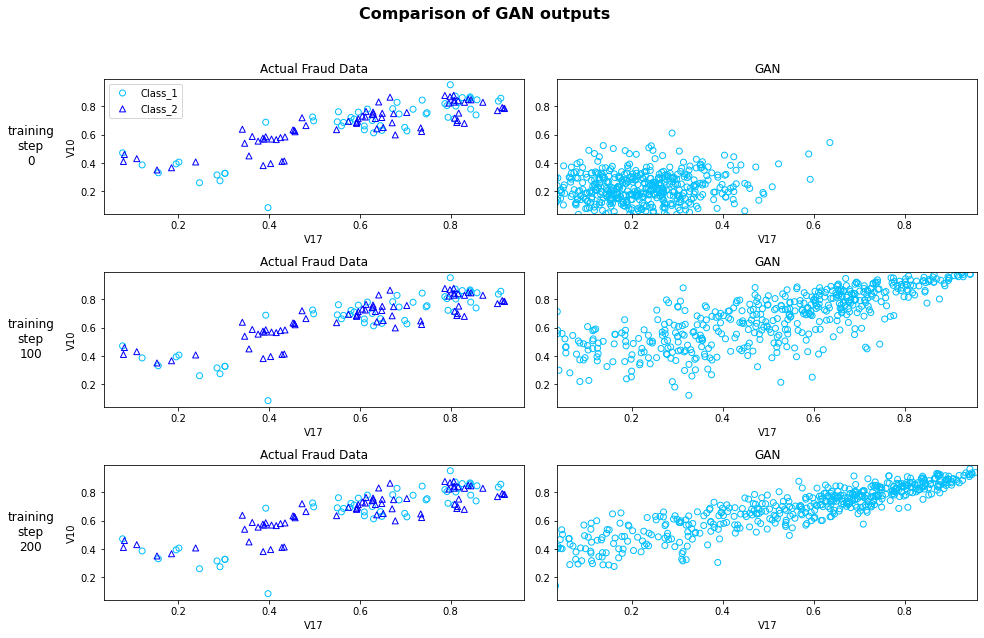

In [16]:
# Setup parameters visualization parameters
seed = 17
test_size = 492 # number of fraud cases
noise_dim = 32

np.random.seed(seed)
z = np.random.normal(size=(test_size, noise_dim))
real_processed = synthesizer.processor.transform(fraud_w_classes)
real_samples = synthesizer.get_data_batch(real_processed, batch_size)
class_labels = ['Class_1','Class_2']
real_samples = pd.DataFrame(real_samples, columns=num_cols+class_labels)
labels = fraud_w_classes['Class']

model_names = ['GAN']
colors = ['deepskyblue','blue']
markers = ['o','^']

col1, col2 = 'V17', 'V10'

base_dir = 'cache/'

# Actual fraud data visualization
model_steps = [ 0, 100, 200]
rows = len(model_steps)
columns = 1 + len(models)

axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(14,rows*3))

# Go through each of the 3 model_step values -> 0, 100, 200
for model_step_ix, model_step in enumerate(model_steps):
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)

    # Plot 'Class 1' and 'Class 2' samples taken from the original data, in a random shuffled fashion
    for group, color, marker, label in zip(real_samples.groupby('Class_1'), colors, markers, class_labels ):
        plt.scatter( group[1][[col1]], group[1][[col2]],
                         label=label, marker=marker, edgecolors=color, facecolors='none' )

    plt.title('Actual Fraud Data')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()

    if model_step_ix == 0:
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')

    # Go through all the GAN models listed in 'model_names' and defined in 'models'
    for i, model_name in enumerate( model_names[:] ):

        [model_name, with_class, generator_model] = models[model_name]

        generator_model.load_weights( base_dir + '_generator_model_weights_step_'+str(model_step)+'.h5')

        ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )

        if with_class:
            g_z = generator_model([z, labels])
            gen_samples = pd.DataFrame(g_z, columns=num_cols+class_labels)
            for group, color, marker, label in zip( gen_samples.groupby('Class_1'), colors, markers, class_labels ):
                plt.scatter( group[1][[col1]], group[1][[col2]],
                                 label=label, marker=marker, edgecolors=color, facecolors='none' )
        else:
            g_z = generator_model(z)
            gen_samples = pd.DataFrame(g_z, columns=num_cols+class_labels)
            gen_samples.to_csv('./data/Generated_sample.csv')
            plt.scatter( gen_samples[[col1]], gen_samples[[col2]],
                             label=class_labels[0], marker=markers[0], edgecolors=colors[0], facecolors='none' )
        plt.title(model_name)
        plt.xlabel(col1)
        ax.set_xlim(xlims), ax.set_ylim(ylims)

plt.suptitle('Comparison of GAN outputs', size=16, fontweight='bold')
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for training steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)

if not os.path.exists("./img"):
    os.makedirs("./img")
plt.savefig('img/Comparison_of_GAN_outputs.png', dpi=100)

# Conclusion
In this tutorial, we successfully demonstated the use of data synthesis using ydataa-synthetic on the Amazon SageMaker instance. It is an simple and easy process to create a notebook instance using Sagmemaker and to generate the synthetic data based on our needs. Truly the new normal of data science.